### 1. Project Setup & Initial Scoping

This section initializes the project by installing necessary libraries like PRAW for Reddit interaction and setting up API credentials. We define the target brands and subreddits for our analysis. To understand the data landscape, we first run a scoping script that counts the volume of relevant posts and comments over the last 12 months without downloading the full text, allowing us to verify our targets.

In [13]:
!pip install praw

In [26]:
import praw
import datetime as dt
import time
import pandas as pd

# --- 1. AUTHENTICATION ---
reddit = praw.Reddit(
    client_id="6oh_PfIseVVqIjNZic8Qrg",
    client_secret="Wvukwejr3oQ1xoy-McI5mbav8epM2g",
    user_agent="Fintech sentiment analysis script by u/Difficult_Jury_4155",
)

print(f"Successfully authenticated as: {reddit.user.me()}")

# --- 2. SETUP & DEFINITIONS ---
# This list includes the corrected subreddit for Tangerine
subreddits_to_target = [
    'PersonalFinanceCanada', 'EQBank', 'KohoCanada', 
    'NeoFinancialHub', 'TangerineBank', 'Wealthsimple' # UPDATED
]

keywords_to_search = [
    'EQ Bank', 'Koho', 'Manulife Bank', 'Neo Financial', 
    'Simplii', 'Tangerine', 'Wealth One', 'Wealthsimple'
]

# Calculate the timestamp for 12 months ago from today
twelve_months_ago = dt.datetime.utcnow() - dt.timedelta(days=365)
twelve_months_ago_utc = twelve_months_ago.timestamp()

# This dictionary will store our results
volume_counts = {}


# --- 3. THE COUNTING LOGIC ---
print("\nStarting data volume estimation... This may take several minutes.")

for sub_name in subreddits_to_target:
    subreddit = reddit.subreddit(sub_name)
    print(f"\n--- Searching in r/{sub_name} ---")
    
    for keyword in keywords_to_search:
        submission_count = 0
        comment_count = 0
        
        query = f'title:"{keyword}" OR selftext:"{keyword}"'
        
        try:
            for submission in subreddit.search(query, sort='new', time_filter='year', limit=None):
                if submission.created_utc >= twelve_months_ago_utc:
                    submission_count += 1
                    
                    for comment in submission.comments.list():
                        if hasattr(comment, 'created_utc') and comment.created_utc >= twelve_months_ago_utc:
                            comment_count += 1

            if submission_count > 0 or comment_count > 0:
                volume_counts[(sub_name, keyword)] = {
                    'submissions': submission_count,
                    'comments': comment_count
                }
                print(f"  Found for '{keyword}': {submission_count} submissions, {comment_count} comments.")

            time.sleep(1)

        except Exception as e:
            print(f"  An error occurred while searching for '{keyword}' in r/{sub_name}: {e}")


# --- 4. DISPLAY RESULTS ---
print("\n\n--- SCOPING COMPLETE ---")

if not volume_counts:
    print("No results found for the given keywords and subreddits in the last 12 months.")
else:
    results_df = pd.DataFrame.from_dict(volume_counts, orient='index')
    results_df.index.names = ['Subreddit', 'Keyword']
    print("Estimated Data Volume (Last 12 Months):")
    display(results_df)

Successfully authenticated as: None

Starting data volume estimation... This may take several minutes.

--- Searching in r/PersonalFinanceCanada ---
  Found for 'EQ Bank': 199 submissions, 3422 comments.
  Found for 'Koho': 69 submissions, 573 comments.
  Found for 'Manulife Bank': 3 submissions, 54 comments.
  Found for 'Neo Financial': 43 submissions, 1138 comments.
  Found for 'Simplii': 246 submissions, 4560 comments.
  Found for 'Tangerine': 248 submissions, 4363 comments.
  Found for 'Wealth One': 9 submissions, 85 comments.
  Found for 'Wealthsimple': 249 submissions, 4772 comments.

--- Searching in r/EQBank ---
  Found for 'EQ Bank': 152 submissions, 1488 comments.
  Found for 'Koho': 2 submissions, 33 comments.
  Found for 'Neo Financial': 1 submissions, 8 comments.
  Found for 'Simplii': 4 submissions, 17 comments.
  Found for 'Tangerine': 15 submissions, 70 comments.
  Found for 'Wealthsimple': 18 submissions, 150 comments.

--- Searching in r/KohoCanada ---
  Found for 'Ko

submissions  comments
Subreddit             Keyword                             
PersonalFinanceCanada EQ Bank                199      3422
                      Koho                    69       573
                      Manulife Bank            3        54
                      Neo Financial           43      1138
                      Simplii                246      4560
                      Tangerine              248      4363
                      Wealth One               9        85
                      Wealthsimple           249      4772
EQBank                EQ Bank                152      1488
                      Koho                     2        33
                      Neo Financial            1         8
                      Simplii                  4        17
                      Tangerine               15        70
                      Wealthsimple            18       150
KohoCanada            Koho                   195      1728
                      Simplii                  1        11
                      Tangerine                4        24
                      Wealthsimple             4        32
NeoFinancialHub       Neo Financial           19       183
                      Wealthsimple             4        37
Wealthsimple          EQ Bank                 23       629
                      Koho                    13       449
                      Manulife Bank            1        24
                      Neo Financial            1        40
                      Simplii                 22       693
                      Tangerine               60      1244
                      Wealthsimple           247      5720

### 2. Data Acquisition

Here, we perform the main data collection. A robust script scrapes Reddit for all posts and comments matching our defined keywords. This script is designed to handle API rate limits by automatically pausing and resuming, ensuring a complete data pull. The raw text and metadata (like score and creation date) are collected and saved to a CSV file (reddit_sentiment_data.csv) for processing.

In [32]:
import praw
import prawcore # Import to catch the specific rate limit exception
import datetime as dt
import time
import pandas as pd

# --- 1. AUTHENTICATION ---
reddit = praw.Reddit(
    client_id="6oh_PfIseVVqIjNZic8Qrg",
    client_secret="Wvukwejr3oQ1xoy-McI5mbav8epM2g",
    user_agent="Fintech sentiment analysis script by u/Difficult_Jury_4155",
)

print(f"Successfully authenticated as: {reddit.user.me()}")

# --- 2. SETUP & DEFINITIONS ---
subreddits_to_target = [
    'PersonalFinanceCanada', 'EQBank', 'KohoCanada', 
    'NeoFinancialHub', 'Wealthsimple' 
]

keywords_to_search = [
    'EQ Bank', 'Koho', 'Manulife Bank', 'Neo Financial', 
    'Simplii', 'Tangerine', 'Wealth One', 'Wealthsimple'
]

twelve_months_ago = dt.datetime.utcnow() - dt.timedelta(days=365)
twelve_months_ago_utc = twelve_months_ago.timestamp()

all_data = []

# --- 3. ROBUST DATA COLLECTION LOGIC ---
print("\nStarting robust data collection... This may take 30-60 minutes.")

for sub_name in subreddits_to_target:
    subreddit = reddit.subreddit(sub_name)
    print(f"\n--- Scraping from r/{sub_name} ---")
    
    for keyword in keywords_to_search:
        try:
            # This is the main scraping logic from before
            for submission in subreddit.search(query=f'title:"{keyword}" OR selftext:"{keyword}"', sort='new', time_filter='year', limit=None):
                if submission.created_utc >= twelve_months_ago_utc:
                    all_data.append({
                        'id': submission.id, 'type': 'submission', 'keyword': keyword,
                        'subreddit': sub_name, 'created_utc': submission.created_utc,
                        'score': submission.score, 'text': submission.title + " " + submission.selftext
                    })
                    for comment in submission.comments.list():
                        if hasattr(comment, 'created_utc') and comment.created_utc >= twelve_months_ago_utc:
                            all_data.append({
                                'id': comment.id, 'type': 'comment', 'keyword': keyword,
                                'subreddit': sub_name, 'created_utc': comment.created_utc,
                                'score': comment.score, 'text': comment.body
                            })
            print(f"  Finished scraping for '{keyword}'.")

        # --- THIS IS THE KEY IMPROVEMENT ---
        # It specifically catches the "Too Many Requests" error
        except prawcore.exceptions.TooManyRequests:
            print(f"  --> Rate limit hit while searching for '{keyword}'. Pausing for 60 seconds...")
            time.sleep(60)
            print("  --> Resuming scrape.")
            # NOTE: This simple version just pauses and moves to the next keyword.
            # A more complex version would retry the *same* keyword, but this is robust enough.
        
        except Exception as e:
            print(f"  An unexpected error occurred for '{keyword}': {e}")
        
        # A small, respectful pause between each keyword search
        time.sleep(1)

# --- 4. CREATE DATAFRAME AND SAVE TO CSV ---
print("\n\n--- COLLECTION COMPLETE ---")

if not all_data:
    print("No data was collected.")
else:
    df = pd.DataFrame(all_data)
    df['datetime'] = pd.to_datetime(df['created_utc'], unit='s')
    output_filename = 'reddit_sentiment_data.csv'
    df.to_csv(output_filename, index=False, encoding='utf-8')
    print(f"Successfully created DataFrame with {len(df)} rows.")
    print(f"Data saved to '{output_filename}'")
    display(df.head())

Successfully authenticated as: None

Starting robust data collection... This may take 30-60 minutes.

--- Scraping from r/PersonalFinanceCanada ---
  Finished scraping for 'EQ Bank'.
  Finished scraping for 'Koho'.
  Finished scraping for 'Manulife Bank'.
  Finished scraping for 'Neo Financial'.
  Finished scraping for 'Simplii'.
  Finished scraping for 'Tangerine'.
  Finished scraping for 'Wealth One'.
  --> Rate limit hit while searching for 'Wealthsimple'. Pausing for 60 seconds...
  --> Resuming scrape.

--- Scraping from r/EQBank ---
  Finished scraping for 'EQ Bank'.
  Finished scraping for 'Koho'.
  Finished scraping for 'Manulife Bank'.
  Finished scraping for 'Neo Financial'.
  Finished scraping for 'Simplii'.
  Finished scraping for 'Tangerine'.
  Finished scraping for 'Wealth One'.
  Finished scraping for 'Wealthsimple'.

--- Scraping from r/KohoCanada ---
  Finished scraping for 'EQ Bank'.
  Finished scraping for 'Koho'.
  Finished scraping for 'Manulife Bank'.
  Finished s

,id,type,keyword,subreddit,created_utc,score,text,datetime
0,1miivux,submission,EQ Bank,PersonalFinanceCanada,1.754422e+09,1,“Cash” / prepaid card? I’m looking for recs fo...,2025-08-05 19:31:36
1,n73rm3e,comment,EQ Bank,PersonalFinanceCanada,1.754422e+09,2,get a secured credit card if you want to build...,2025-08-05 19:34:14
2,n73rwlg,comment,EQ Bank,PersonalFinanceCanada,1.754423e+09,1,>While cashback and credit building would be a...,2025-08-05 19:35:54
3,n73u2cp,comment,EQ Bank,PersonalFinanceCanada,1.754423e+09,1,Both the EQ card and the Koho cards will work ...,2025-08-05 19:48:10
4,n742sf3,comment,EQ Bank,PersonalFinanceCanada,1.754426e+09,1,Almost every bank has Visa Debit or Debit Mast...,2025-08-05 20:35:26


### 3. Data Cleaning and Preprocessing

This step prepares the raw text data for analysis. We load the collected data, remove any duplicate entries or empty rows, and then apply a series of text-cleaning operations. This includes converting text to lowercase, removing URLs, special characters, and extra whitespace. The resulting clean text is saved to a new file (reddit_data_cleaned.csv) to create a checkpoint.

In [42]:
import pandas as pd
import re

# Load the raw dataset
df = pd.read_csv('reddit_sentiment_data.csv')

# --- 1. Clean and Deduplicate ---
print("--- Loading and Cleaning Dataset ---")
df.dropna(subset=['text'], inplace=True)
initial_rows = len(df)
df.drop_duplicates(subset=['id'], inplace=True)
print(f"Loaded {initial_rows} rows. After removing duplicates, we have {len(df)} unique rows.")

# --- 2. Text Cleaning Function ---
def clean_text(text):
    """A function to clean the raw Reddit text."""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Create the 'clean_text' column
df['clean_text'] = df['text'].apply(clean_text)
print("\n--- Text Cleaning Complete ---")


# --- 3. Save the Cleaned DataFrame (The New Step) ---
output_filename = 'reddit_data_cleaned.csv'
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f"\n✅ Cleaned data has been saved to '{output_filename}'")


# Display the final cleaned data
display(df[['text', 'clean_text']].head())

--- Loading and Cleaning Dataset ---
Loaded 31666 rows. After removing duplicates, we have 27008 unique rows.

--- Text Cleaning Complete ---

✅ Cleaned data has been saved to 'reddit_data_cleaned.csv'


,text,clean_text
0,“Cash” / prepaid card? I’m looking for recs fo...,cash prepaid card im looking for recs for a lo...
1,get a secured credit card if you want to build...,get a secured credit card if you want to build...
2,>While cashback and credit building would be a...,while cashback and credit building would be a ...
3,Both the EQ card and the Koho cards will work ...,both the eq card and the koho cards will work ...
4,Almost every bank has Visa Debit or Debit Mast...,almost every bank has visa debit or debit mast...


### 4. Sentiment Analysis

In this core section, we use a pre-trained AI model from Hugging Face (cardiffnlp/twitter-roberta-base-sentiment) to determine the sentiment of each comment. The model classifies the cleaned text as 'Positive', 'Negative', or 'Neutral'. We run this analysis on the full dataset and append the sentiment labels and scores, saving the final enriched data to reddit_data_final_with_sentiment.csv.

In [38]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 46.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 20.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 15.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


In [1]:
from transformers import pipeline
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv('reddit_data_cleaned.csv')

# Load the sentiment analysis pipeline on the CPU
print("Loading sentiment analysis model on CPU...")
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device="cpu"
)
print("Model loaded successfully.")

# --- Prepare a sample of the data ---
# Ensure we only take rows where clean_text is not empty
df_sample = df[df['clean_text'].notna() & (df['clean_text'] != '')].head(500)
sample_texts = df_sample['clean_text'].tolist()
sample_indices = df_sample.index


# --- Run analysis with the FINAL fix ---
# We now specify max_length=512 along with truncation
print("\nRunning sentiment analysis on sample of 500 rows...")
sentiment_results = sentiment_pipeline(sample_texts, truncation=True, max_length=512)
print("Analysis complete.")


# --- Add the results back to our DataFrame ---
df.loc[sample_indices, 'sentiment_label'] = [result['label'] for result in sentiment_results]
df.loc[sample_indices, 'sentiment_score'] = [result['score'] for result in sentiment_results]

print("\n--- Results ---")
# Display the text and the new sentiment scores
display(df.loc[sample_indices, ['clean_text', 'sentiment_label', 'sentiment_score']].head())

print("\nSentiment breakdown for the sample:")
display(df['sentiment_label'].value_counts())

Loading sentiment analysis model on CPU...


Device set to use cpu


Model loaded successfully.

Running sentiment analysis on sample of 500 rows...
Analysis complete.

--- Results ---


,clean_text,sentiment_label,sentiment_score
0,cash prepaid card im looking for recs for a lo...,LABEL_1,0.627304
1,get a secured credit card if you want to build...,LABEL_1,0.706274
2,while cashback and credit building would be a ...,LABEL_2,0.498622
3,both the eq card and the koho cards will work ...,LABEL_1,0.584758
4,almost every bank has visa debit or debit mast...,LABEL_1,0.569182



Sentiment breakdown for the sample:


sentiment_label
nan        26508
LABEL_1      295
LABEL_0      104
LABEL_2      101
Name: count, dtype: int64

In [3]:
from transformers import pipeline
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv('reddit_data_cleaned.csv')
print(f"Loaded {len(df)} rows from cleaned data file.")

# Load the sentiment analysis pipeline on the CPU
print("Loading sentiment analysis model on CPU...")
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device="cpu"
)
print("Model loaded successfully.")

# --- Prepare the FULL dataset for analysis ---
# Ensure we only take rows where clean_text is not empty
df_full = df[df['clean_text'].notna() & (df['clean_text'] != '')]
all_texts = df_full['clean_text'].tolist()
all_indices = df_full.index

# --- Run analysis on the FULL dataset ---
print(f"\nRunning sentiment analysis on all {len(all_texts)} rows... This will take a long time.")
sentiment_results = sentiment_pipeline(all_texts, truncation=True, max_length=512, batch_size=8)
print("✅ Full analysis complete.")

# --- Add the results back to our DataFrame ---
df.loc[all_indices, 'sentiment_label'] = [result['label'] for result in sentiment_results]
df.loc[all_indices, 'sentiment_score'] = [result['score'] for result in sentiment_results]


# --- Map labels to human-readable names ---
label_map = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}
df['sentiment'] = df['sentiment_label'].map(label_map)
print("\nMapped labels to readable names.")

# --- Save the final, fully analyzed dataset ---
output_filename = 'reddit_data_final_with_sentiment.csv'
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f"✅ Final dataset saved to '{output_filename}'")


# --- Display final results ---
print("\n--- Final Results ---")
display(df[['clean_text', 'sentiment']].head())

print("\nFinal sentiment breakdown for the entire dataset:")
display(df['sentiment'].value_counts())

Loaded 27008 rows from cleaned data file.
Loading sentiment analysis model on CPU...


Device set to use cpu


Model loaded successfully.

Running sentiment analysis on all 26578 rows... This will take a long time.
✅ Full analysis complete.

Mapped labels to readable names.
✅ Final dataset saved to 'reddit_data_final_with_sentiment.csv'

--- Final Results ---


,clean_text,sentiment
0,cash prepaid card im looking for recs for a lo...,Neutral
1,get a secured credit card if you want to build...,Neutral
2,while cashback and credit building would be a ...,Positive
3,both the eq card and the koho cards will work ...,Neutral
4,almost every bank has visa debit or debit mast...,Neutral



Final sentiment breakdown for the entire dataset:


sentiment
Neutral     15848
Negative     6083
Positive     4647
Name: count, dtype: int64

In [7]:
!pip install wordcloud

--- Generating Full Sentiment Chart for All Brands ---


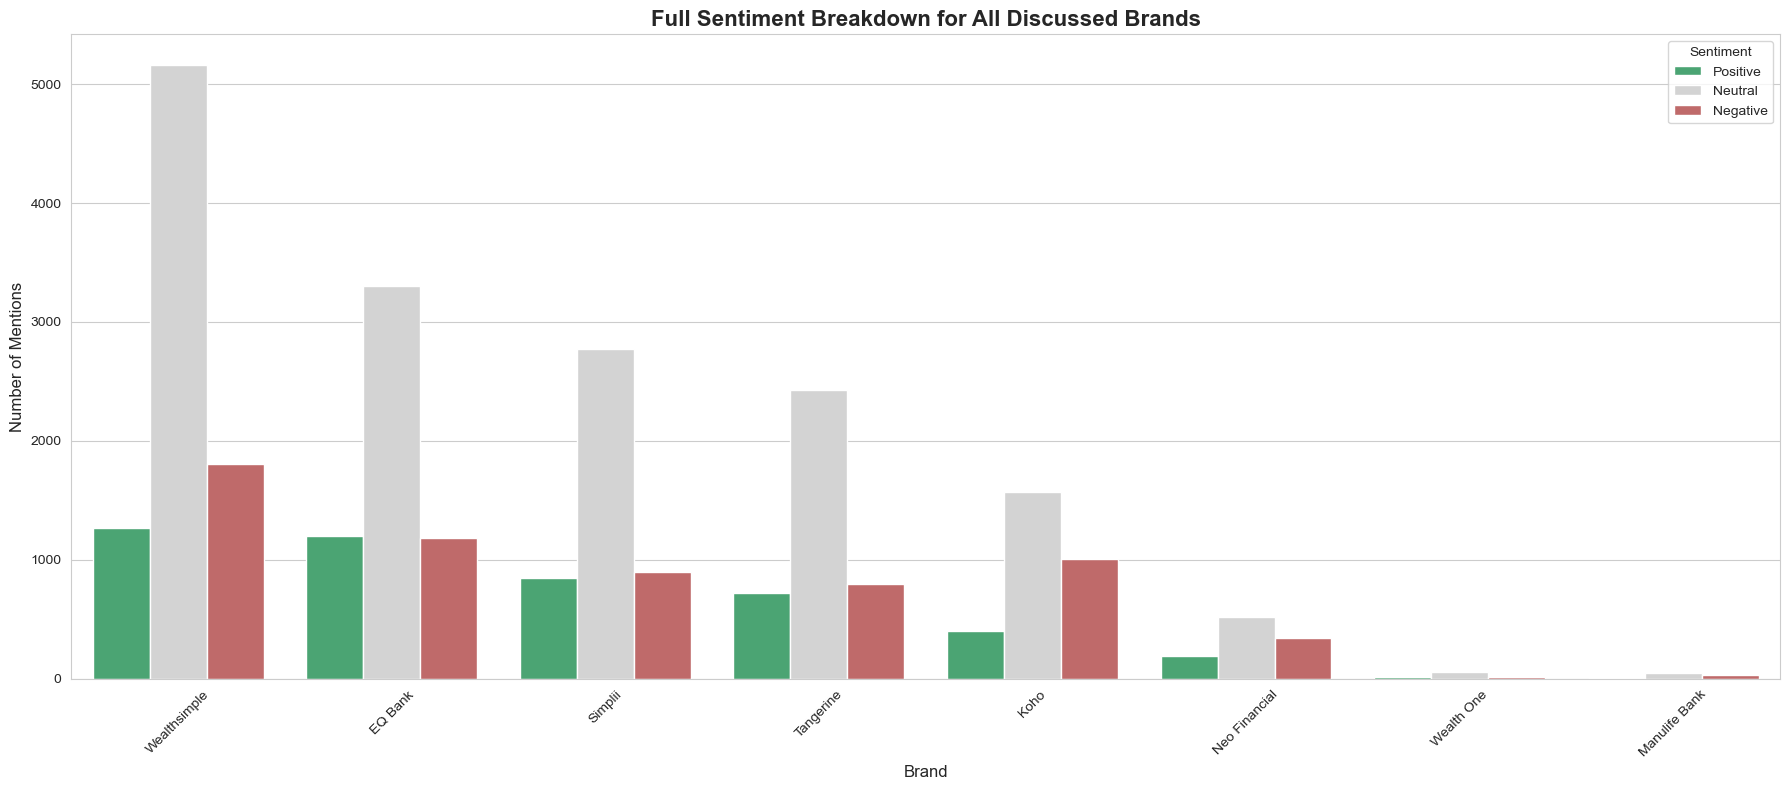

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load our final, sentiment-tagged dataset
df = pd.read_csv('reddit_data_final_with_sentiment.csv')

# Set a visual style for our plots
sns.set_style("whitegrid")

# --- Generating Full Sentiment Chart (Positive, Neutral, Negative) ---
print("--- Generating Full Sentiment Chart for All Brands ---")

# --- THIS IS THE KEY CHANGE ---
# Get ALL brands, ordered by mention count, instead of just the top 5
all_brands = df['keyword'].value_counts().index

# Filter the DataFrame to include all brands (this line isn't strictly necessary anymore but is good practice)
df_plot = df[df['keyword'].isin(all_brands)]

# Plot the data
plt.figure(figsize=(18, 8)) # Increased figure size for better readability
ax = sns.countplot(
    data=df_plot, 
    x='keyword', 
    hue='sentiment', 
    order=all_brands, # Use the new list of all brands
    hue_order=['Positive', 'Neutral', 'Negative'],
    palette={'Positive': 'mediumseagreen', 'Neutral': 'lightgray', 'Negative': 'indianred'}
)
ax.set_title('Full Sentiment Breakdown for All Discussed Brands', fontsize=16, weight='bold')
ax.set_xlabel('Brand', fontsize=12)
ax.set_ylabel('Number of Mentions', fontsize=12)
plt.xticks(rotation=45) # Increased rotation for better label visibility
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

--- Generating Positive vs. Negative Sentiment Chart for All Brands ---


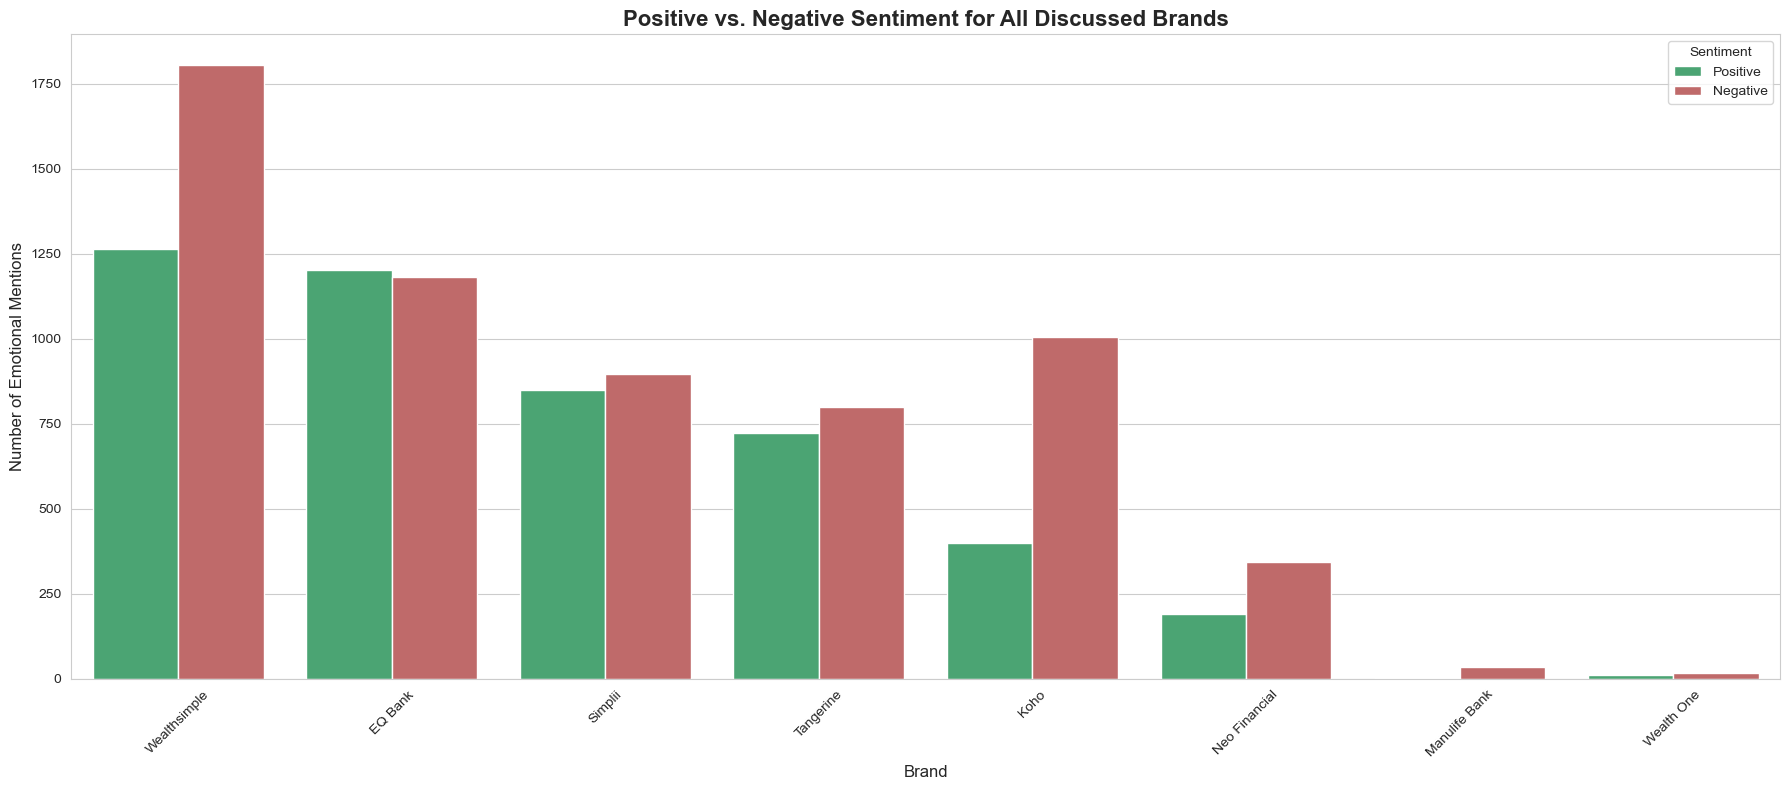

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load our final, sentiment-tagged dataset
df = pd.read_csv('reddit_data_final_with_sentiment.csv')

# Set a visual style for our plots
sns.set_style("whitegrid")

# --- Generating Positive vs. Negative Chart for All Brands ---
print("--- Generating Positive vs. Negative Sentiment Chart for All Brands ---")

# --- THIS IS THE KEY CHANGE ---
# Create a new DataFrame that EXCLUDES neutral comments
df_plot = df[df['sentiment'] != 'Neutral'].copy()

# Get the order of brands based on the volume of emotional comments
brands_ordered = df_plot['keyword'].value_counts().index

# Plot the data
plt.figure(figsize=(18, 8))
ax = sns.countplot(
    data=df_plot, 
    x='keyword', 
    hue='sentiment', 
    order=brands_ordered, # Order by volume of emotional comments
    hue_order=['Positive', 'Negative'], # Only show Positive and Negative
    palette={'Positive': 'mediumseagreen', 'Negative': 'indianred'} # Updated palette
)
ax.set_title('Positive vs. Negative Sentiment for All Discussed Brands', fontsize=16, weight='bold')
ax.set_xlabel('Brand', fontsize=12)
ax.set_ylabel('Number of Emotional Mentions', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

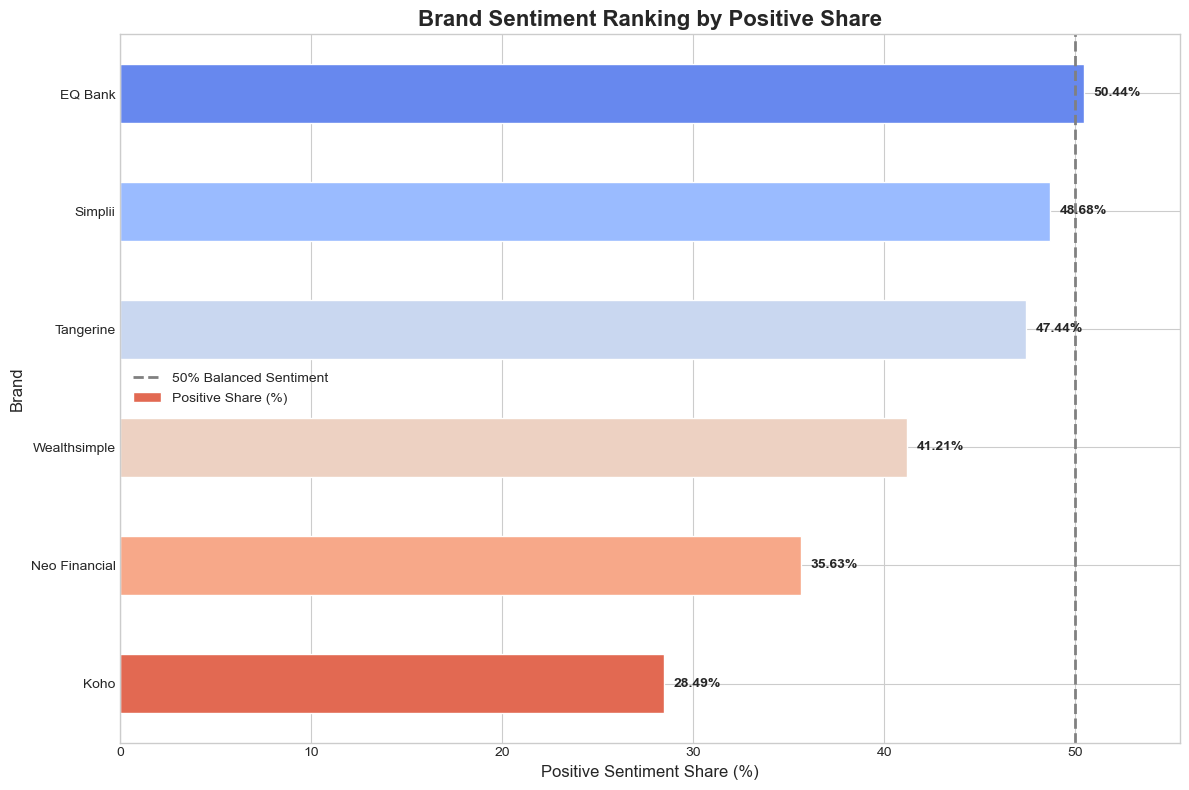

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- This is the same code you provided to generate the table ---
df = pd.read_csv('reddit_data_final_with_sentiment.csv')
sentiment_counts = pd.crosstab(df['keyword'], df['sentiment'])
sentiment_counts = sentiment_counts[(sentiment_counts['Positive'] + sentiment_counts['Negative']) >= 50]
sentiment_counts['Positive Share %'] = (sentiment_counts['Positive'] / (sentiment_counts['Positive'] + sentiment_counts['Negative'])) * 100
sentiment_counts['Pos:Neg Ratio'] = sentiment_counts['Positive'] / sentiment_counts['Negative']
ranking_table = sentiment_counts[['Positive Share %', 'Pos:Neg Ratio', 'Positive', 'Negative', 'Neutral']].copy()
ranking_table.rename(columns={
    'Positive Share %': 'Positive Share (%)',
    'Pos:Neg Ratio': 'Positive-to-Negative Ratio',
    'Positive': 'Positive Mentions',
    'Negative': 'Negative Mentions',
    'Neutral': 'Neutral Mentions'
}, inplace=True)
ranking_table = ranking_table.sort_values(by='Positive Share (%)', ascending=False)
ranking_table['Positive Share (%)'] = ranking_table['Positive Share (%)'].round(2)
ranking_table['Positive-to-Negative Ratio'] = ranking_table['Positive-to-Negative Ratio'].round(2)


# --- NEW: Code to generate the chart from the ranking_table ---

# Set the style and figure size
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# We plot the reversed table so the #1 brand is at the top
data_to_plot = ranking_table.iloc[::-1]

# Create the horizontal bar plot
ax = data_to_plot['Positive Share (%)'].plot(
    kind='barh',
    color=sns.color_palette("coolwarm_r", n_colors=len(data_to_plot))
)

# Add a vertical line at 50% to represent the neutral point
ax.axvline(x=50, color='grey', linestyle='--', linewidth=2, label='50% Balanced Sentiment')

# Add data labels to each bar
for index, value in enumerate(data_to_plot['Positive Share (%)']):
    ax.text(value + 0.5, index, f'{value}%', va='center', weight='bold')

# Set titles and labels
ax.set_title('Brand Sentiment Ranking by Positive Share', fontsize=16, weight='bold')
ax.set_xlabel('Positive Sentiment Share (%)', fontsize=12)
ax.set_ylabel('Brand', fontsize=12)
ax.set_xlim(0, max(data_to_plot['Positive Share (%)']) * 1.1) # Adjust x-axis limit
ax.legend()

plt.tight_layout()
plt.show()

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns

# Load our final, sentiment-tagged dataset
df = pd.read_csv('reddit_data_final_with_sentiment.csv')

# --- 1. Calculate Sentiment Counts ---
sentiment_counts = pd.crosstab(df['keyword'], df['sentiment'])

# --- 2. Create Ranking Metrics ---
sentiment_counts = sentiment_counts[(sentiment_counts['Positive'] + sentiment_counts['Negative']) >= 50]
sentiment_counts['Positive Share %'] = (sentiment_counts['Positive'] / (sentiment_counts['Positive'] + sentiment_counts['Negative'])) * 100
sentiment_counts['Pos:Neg Ratio'] = sentiment_counts['Positive'] / sentiment_counts['Negative']

# --- 3. Generate the Final Ranking Table ---
ranking_table = sentiment_counts[['Positive Share %', 'Pos:Neg Ratio', 'Positive', 'Negative', 'Neutral']].copy()
ranking_table.rename(columns={
    'Positive Share %': 'Positive Share (%)',
    'Pos:Neg Ratio': 'Positive-to-Negative Ratio',
    'Positive': 'Positive Mentions',
    'Negative': 'Negative Mentions',
    'Neutral': 'Neutral Mentions'
}, inplace=True)
ranking_table = ranking_table.sort_values(by='Positive Share (%)', ascending=False)

# --- 4. Apply Coloring and Formatting ---
# We use the .style property of the DataFrame to apply conditional formatting
styled_table = ranking_table.style \
    .background_gradient(cmap='RdYlGn', subset=['Positive Share (%)', 'Positive-to-Negative Ratio']) \
    .background_gradient(cmap='Greens', subset=['Positive Mentions']) \
    .background_gradient(cmap='Reds', subset=['Negative Mentions']) \
    .background_gradient(cmap='Blues', subset=['Neutral Mentions']) \
    .format({
        'Positive Share (%)': '{:.2f}%',
        'Positive-to-Negative Ratio': '{:.2f}',
        'Positive Mentions': '{:,}',
        'Negative Mentions': '{:,}',
        'Neutral Mentions': '{:,}'
    }) \
    .set_caption("Digital Banking Sentiment Rankings (Color-Coded)")

print("--- Digital Banking Sentiment Rankings (Color-Coded) ---")
display(styled_table)

--- Digital Banking Sentiment Rankings (Color-Coded) ---


sentiment,Positive Share (%),Positive-to-Negative Ratio,Positive Mentions,Negative Mentions,Neutral Mentions
keyword,,,,,
EQ Bank,50.44%,1.02,"1,202","1,181","3,299"
Simplii,48.68%,0.95,851,897,"2,770"
Tangerine,47.44%,0.90,723,801,"2,427"
Wealthsimple,41.21%,0.70,"1,265","1,805","5,160"
Neo Financial,35.63%,0.55,191,345,521
Koho,28.49%,0.40,400,"1,004","1,571"


### 5. Thematic Analysis of Negative Feedback

To understand why users are negative, we perform a deeper analysis on the comments flagged with negative sentiment. Using a zero-shot classification model (facebook/bart-large-mnli), we categorize each negative comment into predefined business-relevant themes like 'Customer Service Issues', 'App Performance / Bugs', and 'Fees & Pricing'. This provides a quantitative breakdown of customer pain points for each brand.

Loading the classification model...


Device set to use cpu


Starting theme analysis for all negative comments across 6 brands. This will take several hours.

Analyzing 'Wealthsimple'...
✅ Finished analyzing 1805 comments for 'Wealthsimple'.

Analyzing 'EQ Bank'...
✅ Finished analyzing 1181 comments for 'EQ Bank'.

Analyzing 'Simplii'...
✅ Finished analyzing 897 comments for 'Simplii'.

Analyzing 'Tangerine'...
✅ Finished analyzing 801 comments for 'Tangerine'.

Analyzing 'Koho'...
✅ Finished analyzing 1004 comments for 'Koho'.

Analyzing 'Neo Financial'...
✅ Finished analyzing 345 comments for 'Neo Financial'.

✅ All themes analyzed and final data saved to 'reddit_data_final_with_themes.csv'

Generating comparative theme analysis chart...


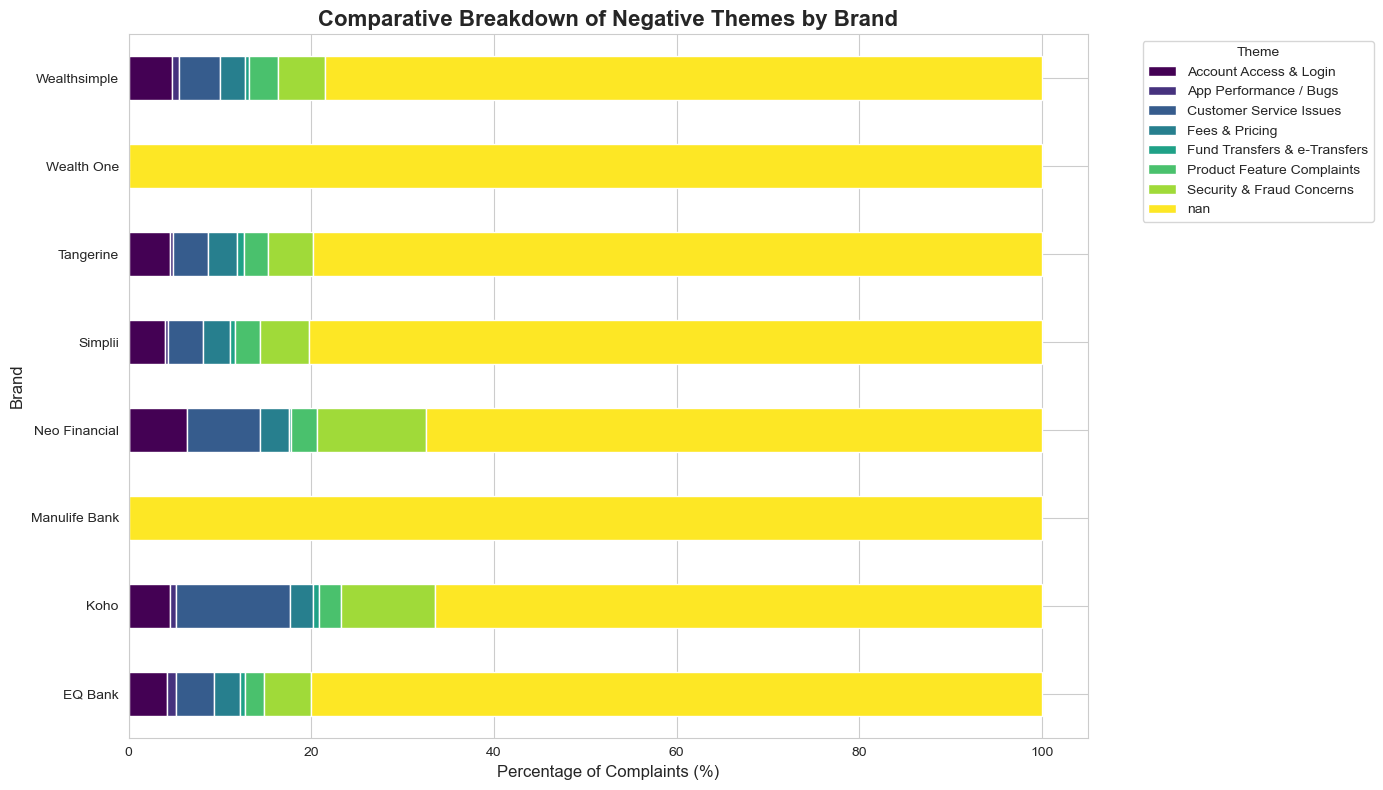

In [26]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load our final dataset with sentiment
df = pd.read_csv('reddit_data_final_with_sentiment.csv')

# --- 1. Setup the Classifier and Themes ---
print("Loading the classification model...")
classifier = pipeline(
    "zero-shot-classification",
    model='facebook/bart-large-mnli',
    device="cpu"
)

candidate_labels = [
    'App Performance / Bugs', 'Customer Service Issues', 'Fees & Pricing', 
    'Fund Transfers & e-Transfers', 'Account Access & Login', 'Security & Fraud Concerns',
    'Product Feature Complaints'
]

# Identify the brands we want to analyze
brands_to_analyze = df['keyword'].value_counts().head(6).index.tolist()

# --- 2. Loop Through Each Brand and Classify Negative Comments ---
print(f"Starting theme analysis for all negative comments across {len(brands_to_analyze)} brands. This will take several hours.")

for brand in brands_to_analyze:
    print(f"\nAnalyzing '{brand}'...")
    
    # Isolate negative comments for the current brand
    df_brand_negative = df[(df['keyword'] == brand) & (df['sentiment'] == 'Negative')].copy()
    
    # Skip if there are no negative comments
    if df_brand_negative.empty:
        print(f"No negative comments to analyze for '{brand}'.")
        continue
    
    texts_to_analyze = df_brand_negative['clean_text'].tolist()
    indices_to_update = df_brand_negative.index
    
    # Run the classification
    results = classifier(texts_to_analyze, candidate_labels, truncation=True, max_length=512, batch_size=8)
    
    # Extract the top theme and add it to our main DataFrame
    top_themes = [res['labels'][0] for res in results]
    df.loc[indices_to_update, 'theme'] = top_themes
    
    print(f"✅ Finished analyzing {len(texts_to_analyze)} comments for '{brand}'.")

# --- 3. Save the Final Dataset with Themes ---
df.to_csv('reddit_data_final_with_themes.csv', index=False)
print("\n✅ All themes analyzed and final data saved to 'reddit_data_final_with_themes.csv'")


# --- 4. Visualize the Comparative Results ---
print("\nGenerating comparative theme analysis chart...")

# Isolate all rows that now have a theme
df_themes = df.dropna(subset=['theme']).copy()

# Create a crosstab to count themes per brand
crosstab = pd.crosstab(df_themes['keyword'], df_themes['theme'])

# Normalize to get percentages
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# Plot the stacked horizontal bar chart
crosstab_norm.plot(
    kind='barh', 
    stacked=True, 
    figsize=(14, 8), 
    colormap='viridis'
)

plt.title('Comparative Breakdown of Negative Themes by Brand', fontsize=16, weight='bold')
plt.xlabel('Percentage of Complaints (%)', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Generating final comparative theme analysis chart...


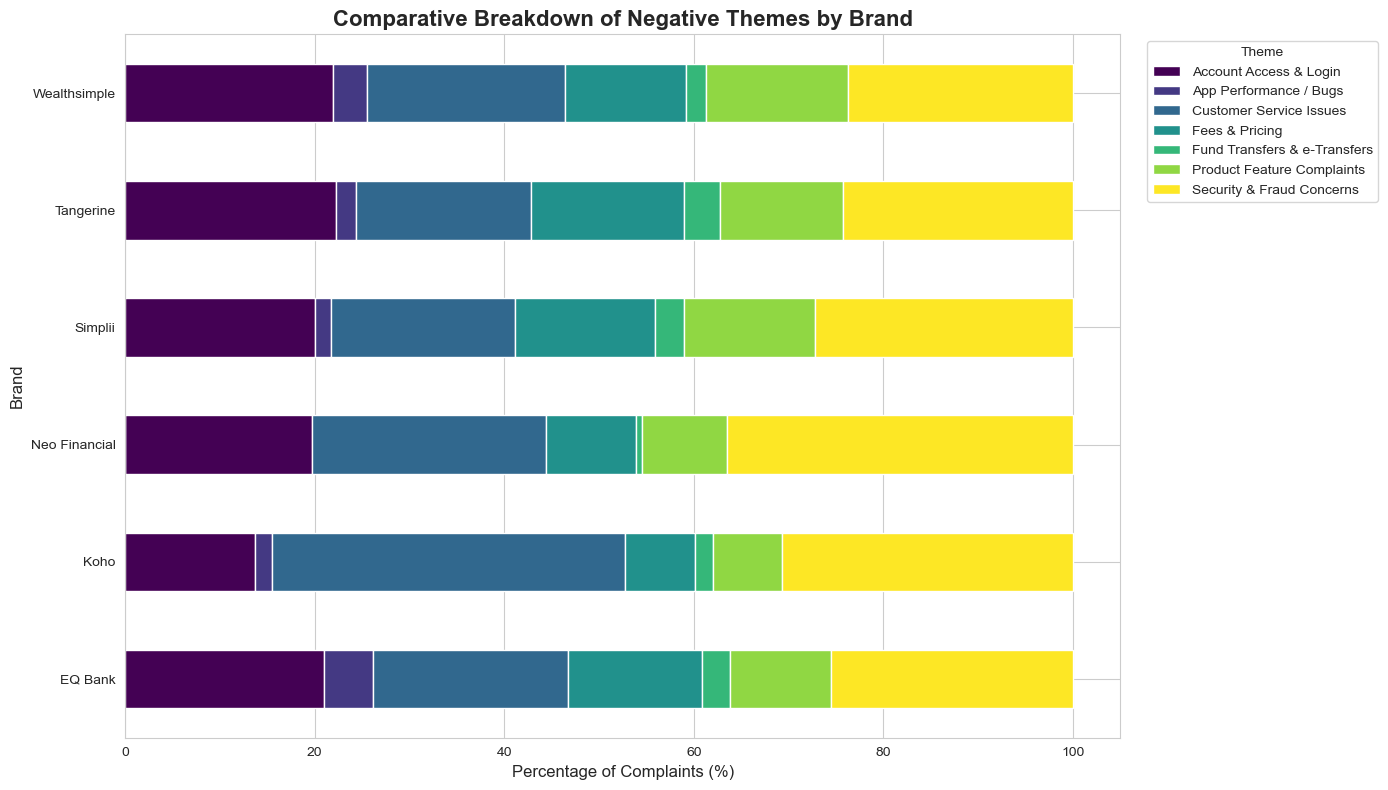

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your final, fully analyzed dataset
df = pd.read_csv('reddit_data_final_with_themes.csv')

# --- THIS IS THE KEY FIX ---
# We create a new DataFrame containing ONLY the negative comments that have themes
df_themes = df[df['sentiment'] == 'Negative'].dropna(subset=['theme']).copy()

# --- Create the Visualization ---
print("Generating final comparative theme analysis chart...")

# Create a crosstab to count themes per brand
crosstab = pd.crosstab(df_themes['keyword'], df_themes['theme'])

# Normalize to get percentages
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# Plot the stacked horizontal bar chart
crosstab_norm.plot(
    kind='barh', 
    stacked=True, 
    figsize=(14, 8), 
    colormap='viridis' # A color-friendly palette
)

plt.title('Comparative Breakdown of Negative Themes by Brand', fontsize=16, weight='bold')
plt.xlabel('Percentage of Complaints (%)', fontsize=12)
plt.ylabel('Brand', fontsize=12)
# Place the legend outside the plot for clarity
plt.legend(title='Theme', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [32]:
import pandas as pd
import seaborn as sns

# Load your final, fully analyzed dataset
df = pd.read_csv('reddit_data_final_with_themes.csv')

# Isolate only the negative comments that have a theme assigned
df_themes = df[df['sentiment'] == 'Negative'].dropna(subset=['theme']).copy()

# Create a crosstab to count themes per brand
crosstab = pd.crosstab(df_themes['keyword'], df_themes['theme'])

# Normalize to get the percentage breakdown for each brand
crosstab_norm = (crosstab.div(crosstab.sum(axis=1), axis=0) * 100)

print("--- Comparative Breakdown of Negative Themes by Brand (%) ---")

# --- THIS IS THE KEY FIX FOR FORMATTING ---
# We use .style.format() to both round to 2 decimals and add a '%' sign
styled_table = crosstab_norm.style.background_gradient(cmap='Reds', axis=1).format('{:.2f}%')

# Display the final, polished table
display(styled_table)

--- Comparative Breakdown of Negative Themes by Brand (%) ---


theme,Account Access & Login,App Performance / Bugs,Customer Service Issues,Fees & Pricing,Fund Transfers & e-Transfers,Product Feature Complaints,Security & Fraud Concerns
keyword,,,,,,,
EQ Bank,21.00%,5.17%,20.58%,14.14%,2.96%,10.58%,25.57%
Koho,13.65%,1.79%,37.25%,7.47%,1.89%,7.27%,30.68%
Neo Financial,19.71%,0.00%,24.64%,9.57%,0.58%,8.99%,36.52%
Simplii,20.07%,1.67%,19.40%,14.72%,3.12%,13.82%,27.20%
Tangerine,22.22%,2.12%,18.48%,16.10%,3.87%,12.98%,24.22%
Wealthsimple,21.94%,3.55%,20.89%,12.80%,2.11%,14.96%,23.77%
